In [43]:
import numpy as np
import re
import requests
from bs4  import BeautifulSoup as soup
from tqdm import tqdm
import networkx as nx
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pychord import Chord, ChordProgression
import itertools
import pickle
%matplotlib inline

In [7]:
## pickle.dump() pickle.load

In [8]:
def from_artist(artistname, pages=1):
    links = []
    dirty = []
    names = []
    for page in tqdm(range(1,pages+1)):
        url = "https://www.ultimate-guitar.com/artist/"+artistname+f"?page={page}"
#         print(url)
        s = requests.get(url)
        # s = soup(s.text, 'html.parser')
        t = s.text

        alltext = re.findall(r'&quot;tab_url&quot;:&quot;(.*?)&quot;,&quot;',t)
#         print(len(alltext),'\n\n')
        for i in alltext:
            if '/pro/' in i:
                continue
            dirty.append(i)
            current = re.search(r'https://tabs.ultimate-guitar.com/tab/[\w-]+/([\w-]+)-\w+-\d+',i)
            name = current.group(1)
            if name not in names:
                names.append(name)
            else:
                continue
            links.append(i)
    return (links, dirty, names)
def tofile(l, filepath):
    with open(filepath, 'w') as f:
        f.writelines([i+'\n' for i in l])


In [9]:
# links, dirty, songs = from_artist('the_beatles_1916',30)
# tofile(links,'linksbig.txt')
# tofile(dirty, 'dirtybig.txt')

In [10]:
# name = "the_beatles_1916"
# page = '2'
# url = "https://www.ultimate-guitar.com/artist/"+name+f"?page={page}"

# s = requests.get(url)
# # s = soup(s.text, 'html.parser')
# t = s.text

# alltext = re.findall(r'&quot;tab_url&quot;:&quot;(.*?)&quot;,&quot;',t)
# links = []
# dirty = []
# names = []
# for i in alltext:
#     if '/pro/' in i:
#         continue
#     dirty.append(i)
#     current = re.search(r'https://tabs.ultimate-guitar.com/tab/[\w-]+/([\w-]+)-\w+-\d+',i)
#     name = current.group(1)
#     if name not in names:
#         names.append(name)
#     else:
#         continue
#     links.append(i)
# (links, dirty)

In [37]:
class SongChords:
    def __init__(self, c, G):
        self.c = c
        self.G = G
    def get(self):
        return (self.c, self.G)


In [12]:
      
def pickle_song(G):
    pass

In [ ]:
def saveartist(artist):
    pass

In [ ]:
def make_csv(url1,url2):
    pass

In [13]:
def chord_tonality(url):
    try:
        s = requests.get(url)
    except:
        print('error\n\n')
        return None, None
    m = re.search(r'{&quot;content&quot;:&quot;(.+)&quot;,&quot;revision_id&quot;',s.text)
    if m is None:
        return None, None
    tonal = re.search(r'tonality&quot;:&quot;(\w+)&quot;', s.text)
    if tonal is not None:
        tonal = re.search(r'tonality&quot;:&quot;(\w+)&quot;', s.text).group(1)
    return [re.findall(r'\[ch\]([\w#\.-]+)\[\/ch\]',m.group(1)), tonal]

In [32]:
def g_list(filepath,drawsize=10, changetone=None, iters=0):
    numsongs = 0
    # str int str
    with open(filepath) as f:
        lines  = f.readlines()
    urls = [i[:-1] for i in lines]
    G = nx.MultiDiGraph()
    if iters==0: 
        iters = len(urls)
    for url in tqdm(urls):
        chords, tone = chord_tonality(url)
        if chords is None:
#             print('report!')
            continue
        if changetone is not None:
            if tone is None:
#                 print('reporttone!')
                continue
            cc = []
            for c in chords:
                c = re.sub('mMaj','m',c)
                cc.append(c)
            chords = cc
            prog  =  ChordProgression(chords)
            prog.transpose(trans(changetone, tone))
            chords = []
            for i in prog:
                chords.append(str(i))
        ch = zip(chords[:-1],chords[1:])
        ch =  [i for i in ch]
        G.add_edges_from(ch)
#         with open('goodpath.txt','a') as ff:
#             ff.write(url+'\n')
        print('okay!!!')
        numsongs+=1
        if numsongs>=iters: break
    weights = [0 for i in G.edges]
    for i,e in enumerate(G.edges):
        weights[i] =  np.log(e[2]+2)
    plt.figure(figsize=(drawsize,drawsize))
    print(numsongs)
    nx.draw_networkx(G, width=weights )
    return G

In [15]:
def trans(target, current):
    # target -> current
    keytable = {'C': 0, 'Db': 1, 'C#': 1, 'D': 2, 'Eb': 3, 'D#':3, 'E': 4, 'F': 5, 'Gb': 6, 'F#':6, 'G': 7, 'Ab': 8, 'G#':8, 'A': 9, 'Bb': 10, 'A#': 10, 'B': 11}
    
    n = keytable.get(target)-keytable.get(current)
    return n

## use case
# chords = ['F','Em7','A7','Dm']
# tone = 'F'
# prog  =  ChordProgression(chords)
# prog.transpose(trans('C', tone))
# print(prog)

C | Bm7 | E7 | Am


In [18]:
def g_song(url,drawsize=10, changetone=None):
    # str int str
    chords, tone = chord_tonality(url)
    if chords is None:
        print('report!')
        return None
    if changetone is not None:
        if tone is None:
            print('reporttone!')
            return None
        prog  =  ChordProgression(chords)
        prog.transpose(trans(changetone, tone))
        chords = []
        for i in prog:
            chords.append(str(i))
    ch = zip(chords[:-1],chords[1:])
    ch =  [i for i in ch]
    G = nx.MultiDiGraph()
    G.add_edges_from(ch)
    weights = [0 for i in G.edges]
    for i,e in enumerate(G.edges):
        weights[i] =  np.log(e[2]+2)
    plt.figure(figsize=(drawsize,drawsize))
    nx.draw_networkx(G, width=weights )
    return (G, chords)
def from_chords(chords,drawsize=10, changetone=None):
    ch = zip(chords[:-1],chords[1:])
    ch =  [i for i in ch]
    G = nx.MultiDiGraph()
    G.add_edges_from(ch)
    weights = [0 for i in G.edges]
    for i,e in enumerate(G.edges):
        weights[i] =  np.log(e[2]+2)
    plt.figure(figsize=(drawsize,drawsize))
    nx.draw_networkx(G, width=weights )
    return G
def fromG(G, drawsize=10, changetone=None):
    weights = [0 for i in G.edges]
    for i,e in enumerate(G.edges):
        weights[i] =  np.log(e[2]+2)
    plt.figure(figsize=(drawsize,drawsize))
    nx.draw_networkx(G, width=weights )

In [ ]:
# gg,cc = g_song(links[0])
# print(gg,cc)
# S = SongChords(cc,gg)
# from_chords(cc)
# pickle.dump(S, open('s1.pickle','wb'))
# ss = pickle.load(open('s1.pickle','rb'))
# type(ss)
# from_chords(ss.get()[0])

In [ ]:
glinks = g_list('dirty.txt',drawsize = 24, changetone='C')

In [ ]:
g_list('dirtycopy.txt',drawsize = 24)

/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


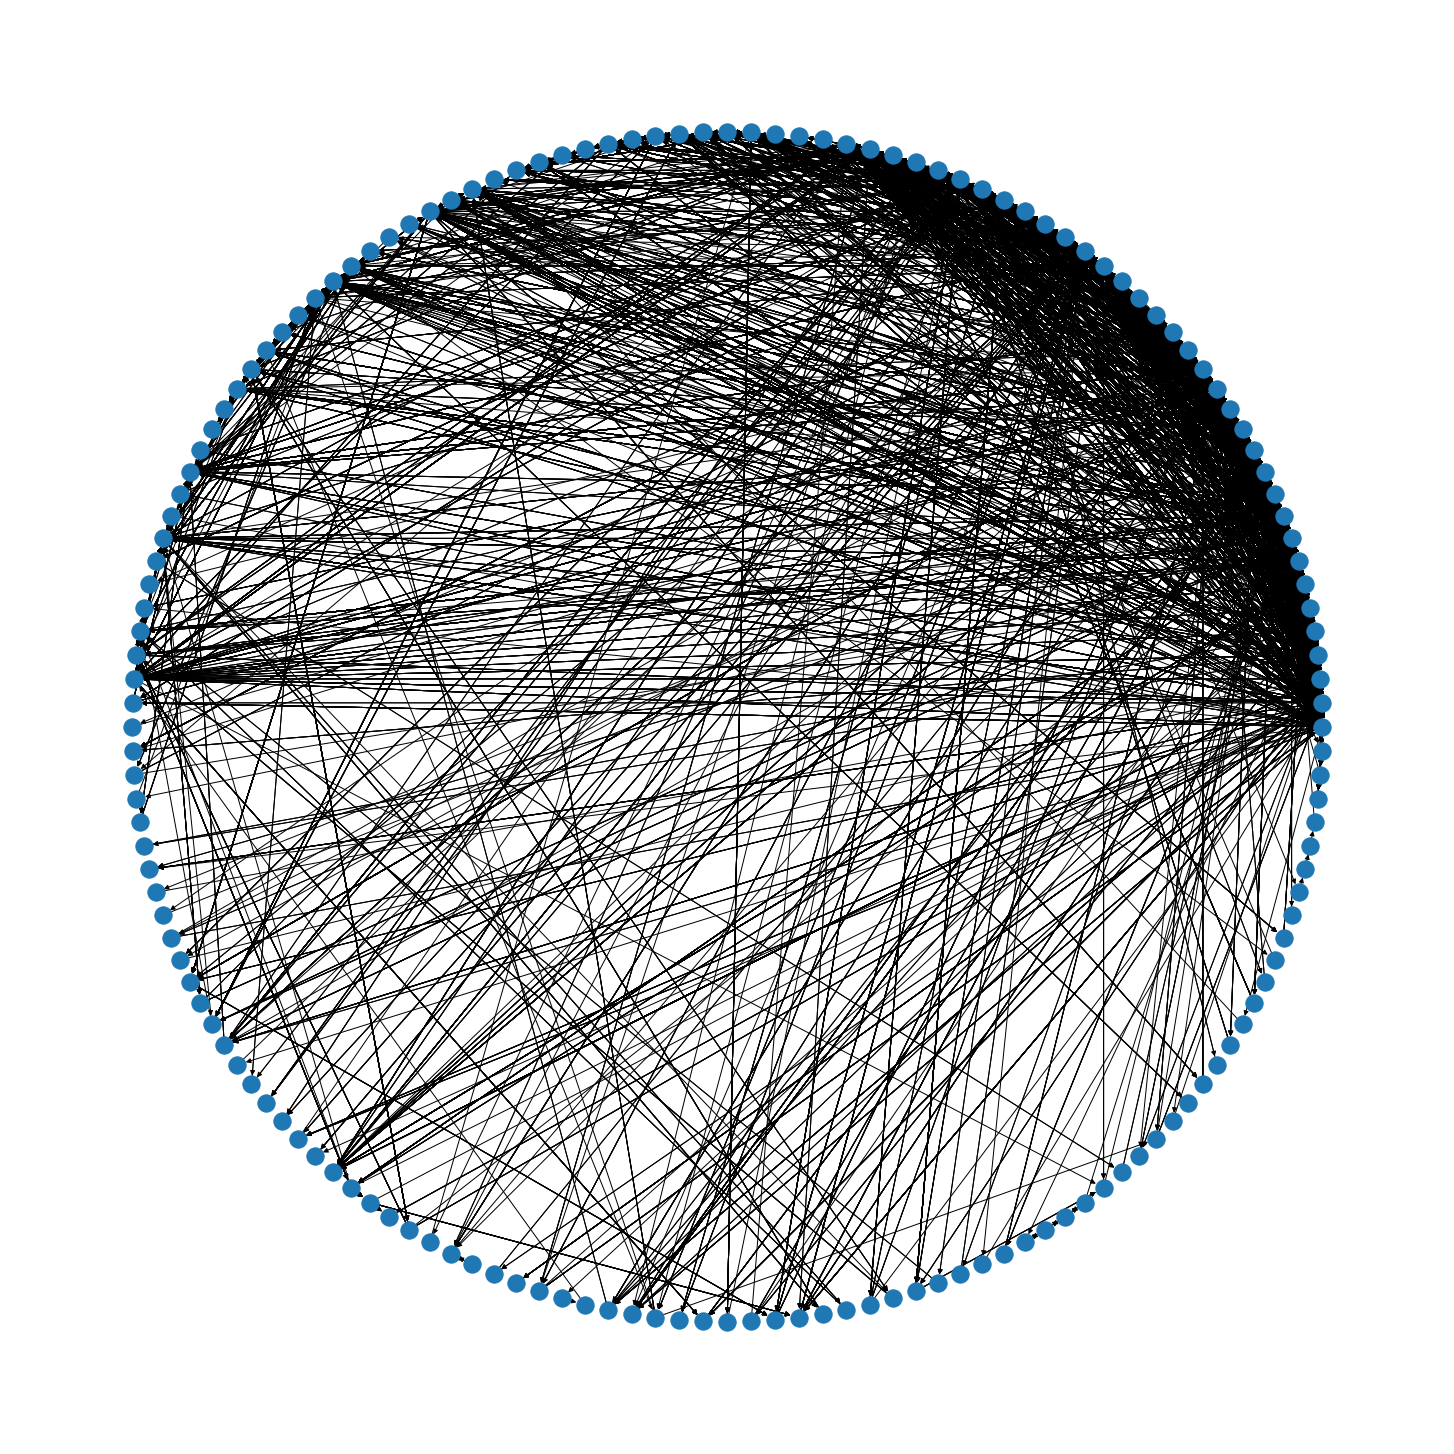

In [64]:
plt.figure(figsize=(20,20))
nx.draw_circular(glinks)

In [ ]:
gdirty = g_list('dirty.txt')

In [ ]:
Chord('Am')

  3%|▎         | 1/31 [00:00<00:20,  1.46it/s]

okay!!!


  6%|▋         | 2/31 [00:01<00:19,  1.45it/s]

okay!!!


 10%|▉         | 3/31 [00:02<00:19,  1.42it/s]

okay!!!


 13%|█▎        | 4/31 [00:02<00:18,  1.43it/s]

okay!!!


 16%|█▌        | 5/31 [00:03<00:17,  1.48it/s]

okay!!!


 19%|█▉        | 6/31 [00:04<00:16,  1.52it/s]

okay!!!


 23%|██▎       | 7/31 [00:04<00:15,  1.56it/s]

okay!!!


 26%|██▌       | 8/31 [00:05<00:15,  1.50it/s]

okay!!!


 29%|██▉       | 9/31 [00:06<00:15,  1.46it/s]

okay!!!


 32%|███▏      | 10/31 [00:06<00:13,  1.50it/s]

okay!!!


 35%|███▌      | 11/31 [00:07<00:14,  1.42it/s]

okay!!!


 39%|███▊      | 12/31 [00:08<00:13,  1.39it/s]

okay!!!


 42%|████▏     | 13/31 [00:09<00:13,  1.35it/s]

okay!!!


 45%|████▌     | 14/31 [00:09<00:12,  1.36it/s]

okay!!!


 48%|████▊     | 15/31 [00:10<00:11,  1.43it/s]

okay!!!


 52%|█████▏    | 16/31 [00:11<00:10,  1.49it/s]

okay!!!


 55%|█████▍    | 17/31 [00:11<00:10,  1.40it/s]

okay!!!


 58%|█████▊    | 18/31 [00:12<00:08,  1.48it/s]

okay!!!


 61%|██████▏   | 19/31 [00:12<00:07,  1.58it/s]

okay!!!


 65%|██████▍   | 20/31 [00:13<00:06,  1.58it/s]

okay!!!


 68%|██████▊   | 21/31 [00:14<00:06,  1.60it/s]

okay!!!


 71%|███████   | 22/31 [00:14<00:05,  1.65it/s]

okay!!!


 74%|███████▍  | 23/31 [00:15<00:04,  1.68it/s]

okay!!!


 77%|███████▋  | 24/31 [00:16<00:04,  1.58it/s]

okay!!!


 81%|████████  | 25/31 [00:16<00:04,  1.46it/s]

okay!!!


 84%|████████▍ | 26/31 [00:17<00:03,  1.50it/s]

okay!!!


 87%|████████▋ | 27/31 [00:18<00:02,  1.46it/s]

okay!!!


 90%|█████████ | 28/31 [00:18<00:01,  1.52it/s]

okay!!!


 94%|█████████▎| 29/31 [00:19<00:01,  1.54it/s]

okay!!!


 97%|█████████▋| 30/31 [00:20<00:00,  1.38it/s]

okay!!!


100%|██████████| 31/31 [00:20<00:00,  1.48it/s]

okay!!!
31



/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/xieewenz/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


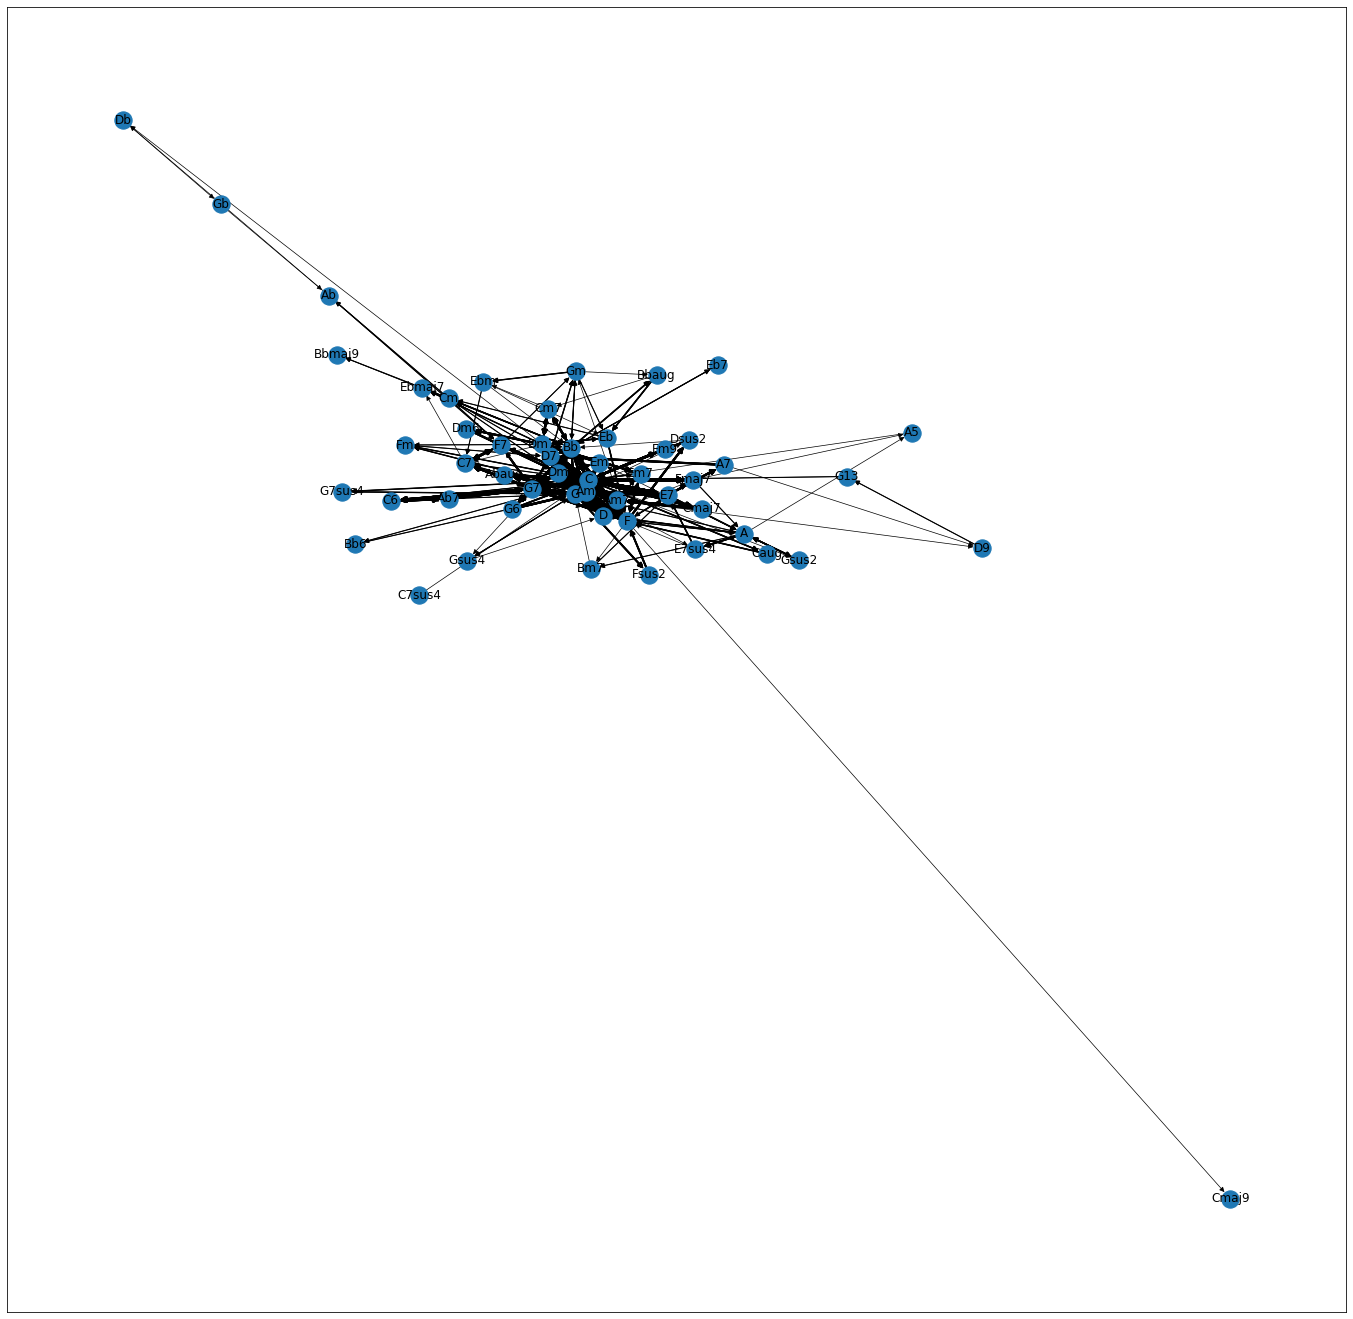

In [30]:
gdirtybig = g_list('goodpath.txt',drawsize = 24, changetone='C')

In [5]:
        with open('goodpath.txt','a') as ff:
            ff.write('asdads'+'\n')

  3%|▎         | 1/31 [00:00<00:22,  1.33it/s]

okay!!!


  6%|▋         | 2/31 [00:01<00:20,  1.41it/s]

okay!!!


 10%|▉         | 3/31 [00:02<00:19,  1.45it/s]

okay!!!


 13%|█▎        | 4/31 [00:02<00:17,  1.52it/s]

okay!!!


 16%|█▌        | 5/31 [00:03<00:17,  1.49it/s]

okay!!!


 19%|█▉        | 6/31 [00:03<00:16,  1.53it/s]

okay!!!


 23%|██▎       | 7/31 [00:04<00:15,  1.55it/s]

okay!!!


 26%|██▌       | 8/31 [00:05<00:15,  1.50it/s]

okay!!!


 29%|██▉       | 9/31 [00:05<00:13,  1.60it/s]

okay!!!


 32%|███▏      | 10/31 [00:06<00:12,  1.62it/s]

okay!!!


 35%|███▌      | 11/31 [00:06<00:12,  1.63it/s]

okay!!!


 39%|███▊      | 12/31 [00:07<00:11,  1.62it/s]

okay!!!


 42%|████▏     | 13/31 [00:08<00:11,  1.63it/s]

okay!!!


 45%|████▌     | 14/31 [00:08<00:10,  1.55it/s]

okay!!!


 48%|████▊     | 15/31 [00:09<00:10,  1.50it/s]

okay!!!


 52%|█████▏    | 16/31 [00:10<00:09,  1.53it/s]

okay!!!


 55%|█████▍    | 17/31 [00:10<00:08,  1.61it/s]

okay!!!


 58%|█████▊    | 18/31 [00:11<00:07,  1.64it/s]

okay!!!


 61%|██████▏   | 19/31 [00:11<00:06,  1.74it/s]

okay!!!


 65%|██████▍   | 20/31 [00:12<00:06,  1.59it/s]

okay!!!


 68%|██████▊   | 21/31 [00:13<00:06,  1.62it/s]

okay!!!


 71%|███████   | 22/31 [00:13<00:05,  1.69it/s]

okay!!!


 74%|███████▍  | 23/31 [00:14<00:05,  1.59it/s]

okay!!!


 77%|███████▋  | 24/31 [00:15<00:04,  1.62it/s]

okay!!!


 81%|████████  | 25/31 [00:15<00:03,  1.62it/s]

okay!!!


 84%|████████▍ | 26/31 [00:16<00:03,  1.61it/s]

okay!!!


 87%|████████▋ | 27/31 [00:16<00:02,  1.68it/s]

okay!!!


 90%|█████████ | 28/31 [00:17<00:01,  1.52it/s]

okay!!!


 94%|█████████▎| 29/31 [00:18<00:01,  1.63it/s]

okay!!!


 97%|█████████▋| 30/31 [00:18<00:00,  1.57it/s]

okay!!!


100%|██████████| 31/31 [00:19<00:00,  1.58it/s]

okay!!!
31


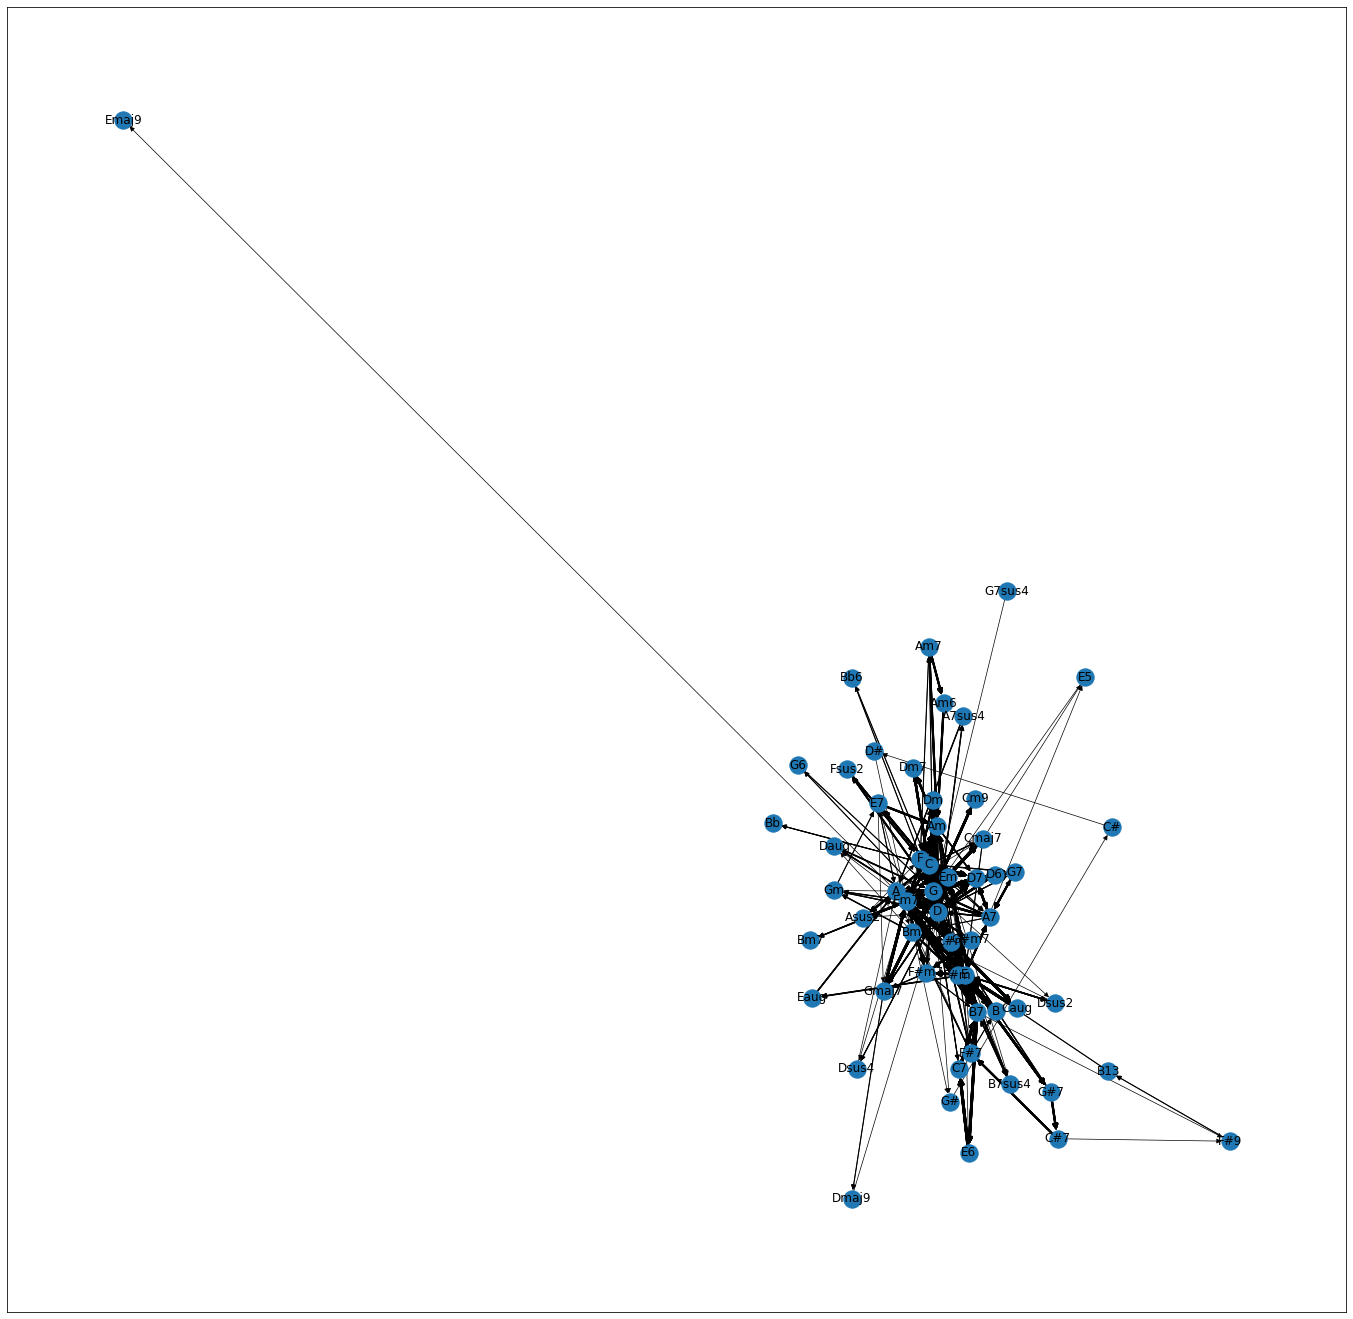

In [31]:
gdirtybig = g_list('goodpath.txt',drawsize = 24)

  3%|▎         | 1/31 [00:00<00:21,  1.42it/s]

okay!!!


  6%|▋         | 2/31 [00:01<00:21,  1.35it/s]

okay!!!


 10%|▉         | 3/31 [00:02<00:19,  1.41it/s]

okay!!!


 13%|█▎        | 4/31 [00:02<00:18,  1.48it/s]

okay!!!


 16%|█▌        | 5/31 [00:03<00:16,  1.60it/s]

okay!!!


 19%|█▉        | 6/31 [00:03<00:15,  1.62it/s]

okay!!!


 23%|██▎       | 7/31 [00:04<00:14,  1.69it/s]

okay!!!


 26%|██▌       | 8/31 [00:05<00:14,  1.60it/s]

okay!!!


 29%|██▉       | 9/31 [00:05<00:12,  1.70it/s]

okay!!!


 29%|██▉       | 9/31 [00:06<00:15,  1.46it/s]

okay!!!
10


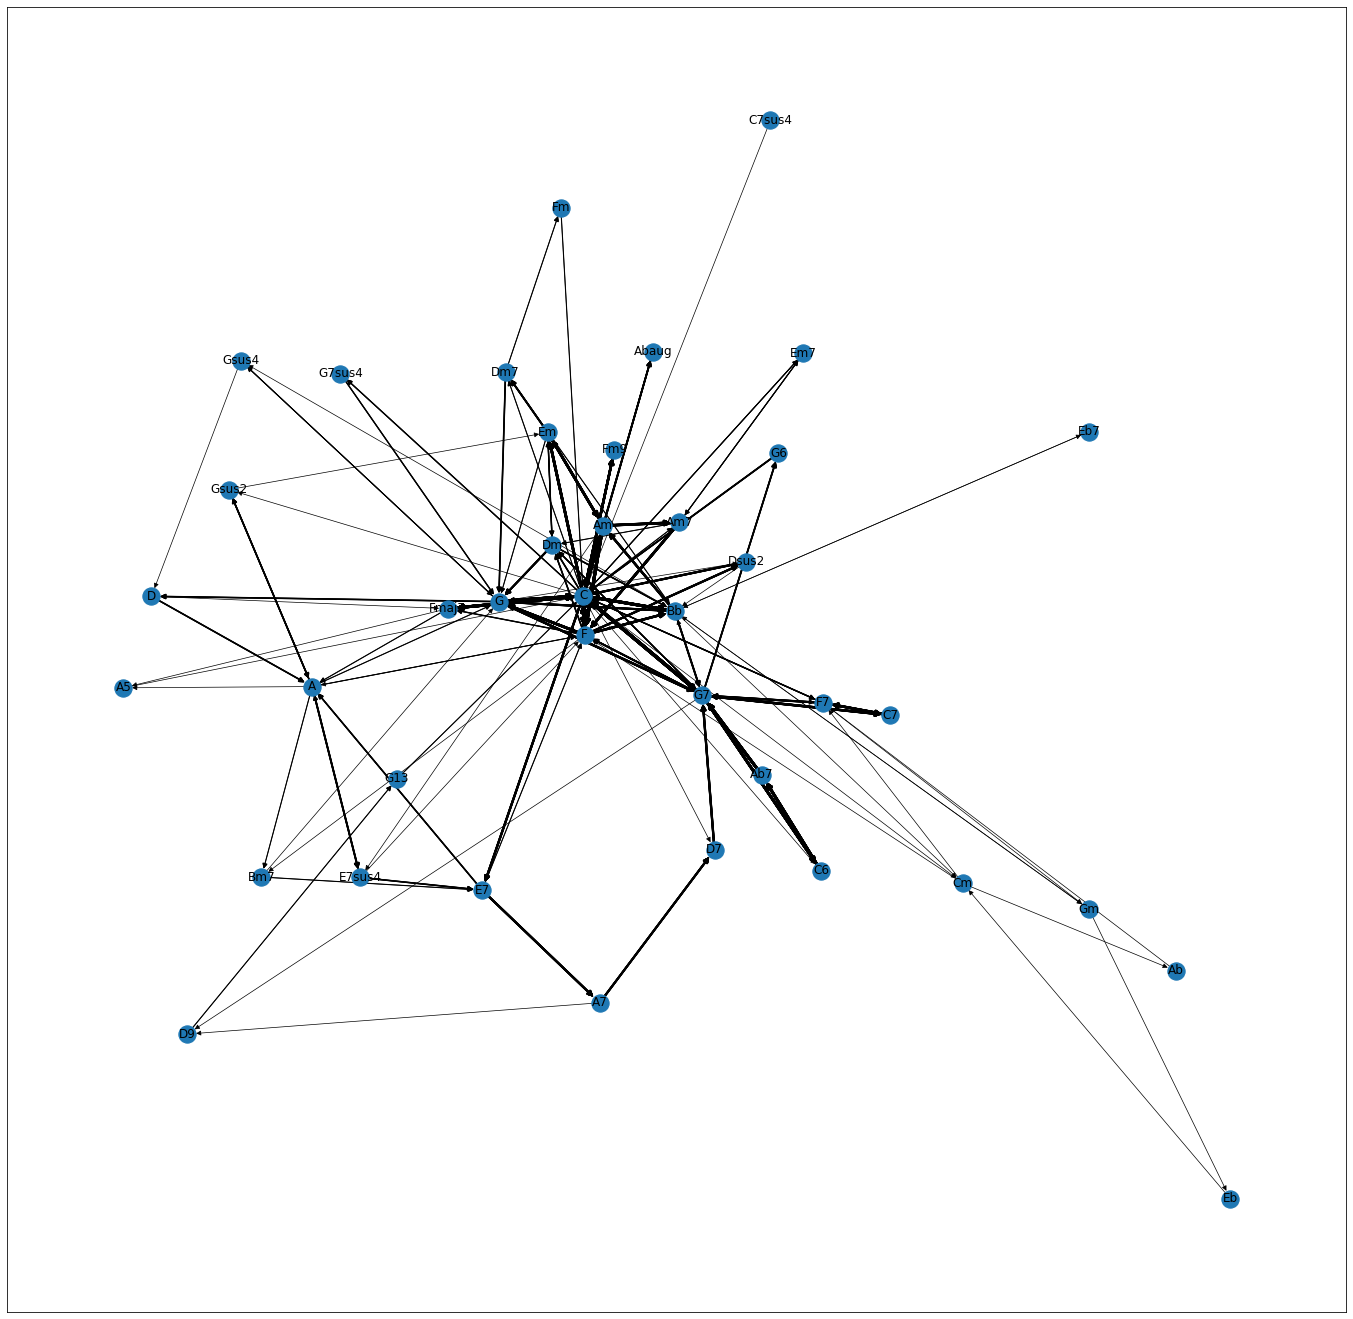

In [35]:
gdirtybig = g_list('goodpath.txt',drawsize = 24, changetone='C', iters=10)

  3%|▎         | 1/31 [00:00<00:26,  1.15it/s]

okay!!!


  6%|▋         | 2/31 [00:01<00:22,  1.26it/s]

okay!!!


 10%|▉         | 3/31 [00:02<00:20,  1.34it/s]

okay!!!


 13%|█▎        | 4/31 [00:02<00:20,  1.31it/s]

okay!!!


 16%|█▌        | 5/31 [00:03<00:18,  1.40it/s]

okay!!!


 19%|█▉        | 6/31 [00:04<00:16,  1.52it/s]

okay!!!


 23%|██▎       | 7/31 [00:04<00:15,  1.56it/s]

okay!!!


 26%|██▌       | 8/31 [00:05<00:14,  1.62it/s]

okay!!!


 29%|██▉       | 9/31 [00:05<00:13,  1.58it/s]

okay!!!


 29%|██▉       | 9/31 [00:06<00:15,  1.38it/s]

okay!!!
10


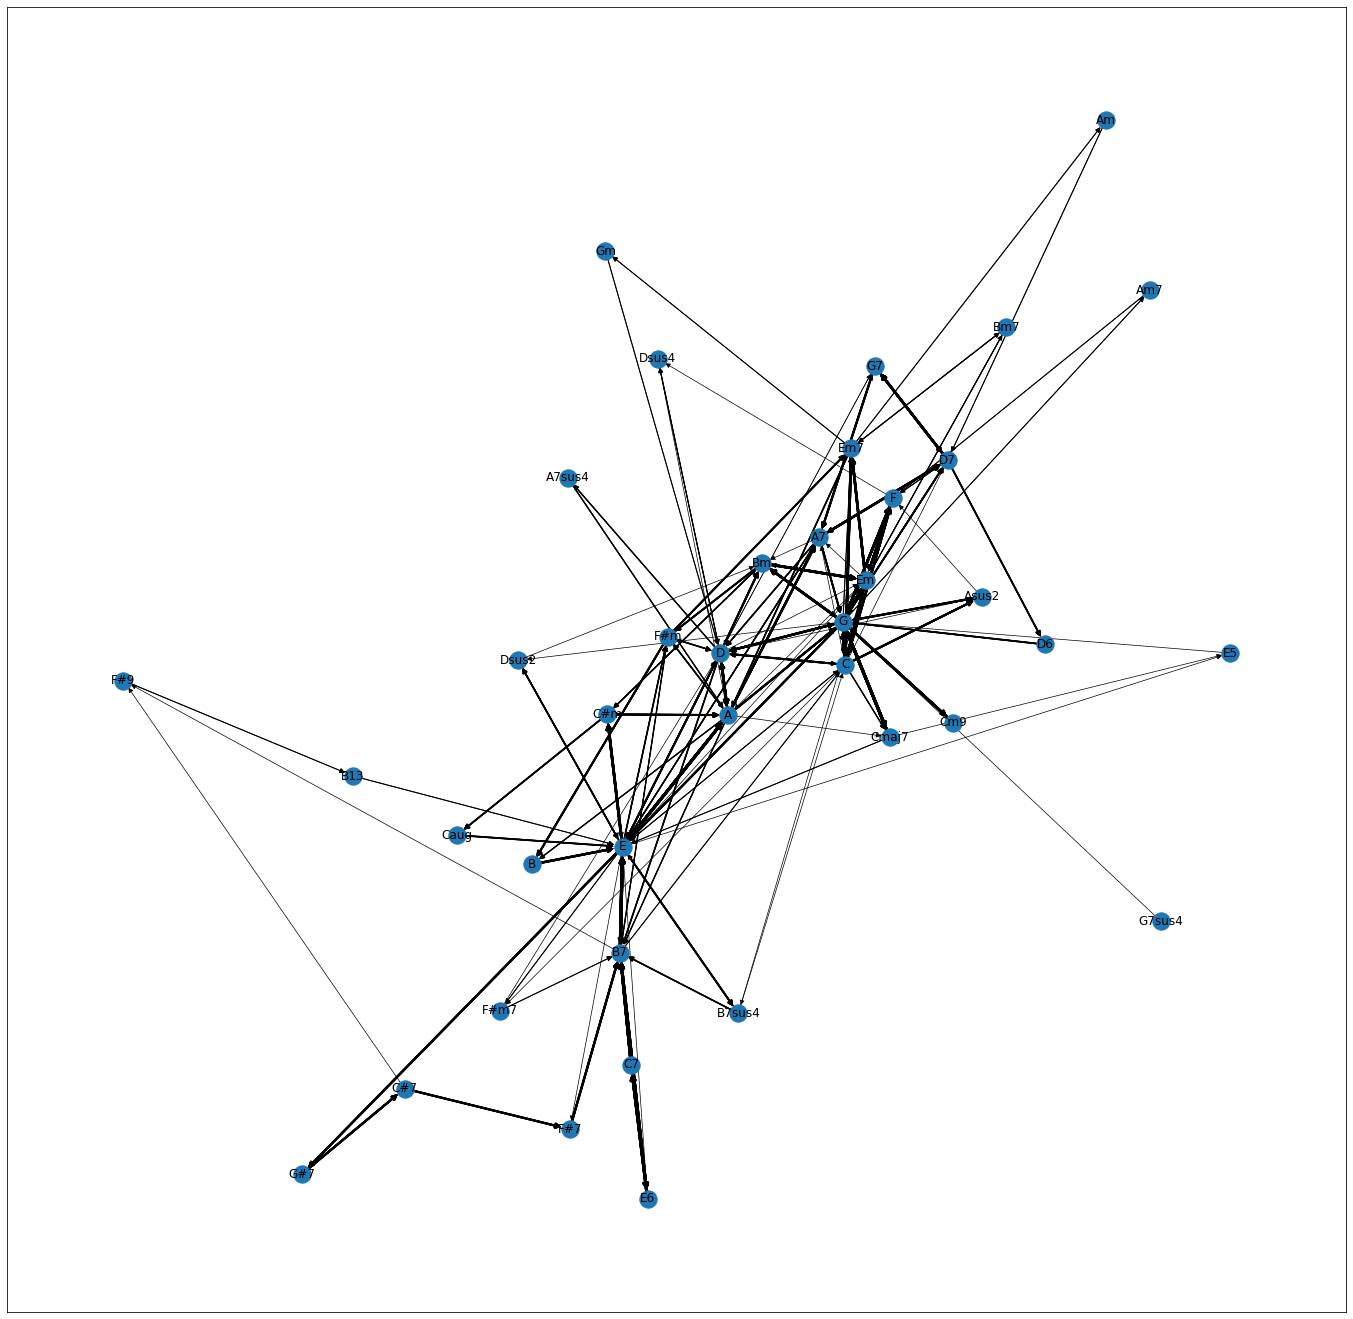

In [36]:
gdirtybig = g_list('goodpath.txt',drawsize = 24, iters=10)

/Users/xieewenz/.pyenv/shims/pip3
